In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [4]:
from src.lime_timeseries_optimized import *
from keras.engine.saving import load_model
import time
from matplotlib import pyplot as plt
import matplotlib
import mpld3
import plotly.tools as tls
# select a set of background examples to take an expectation over
training_set = np.load('/home/justyna/WORKSPACE/heartbeat_classification/data/processed/preprocessed/physionet/serialized/no_feature_extraction/train.npy')
x_test = np.load('/home/justyna/WORKSPACE/heartbeat_classification/data/processed/preprocessed/physionet/serialized/no_feature_extraction/test.npy')
MODEL = load_model('/home/justyna/WORKSPACE/heartbeat_classification/src/flask-app/convo_weights.h5')
training_labels = np.load('/home/justyna/WORKSPACE/heartbeat_classification/data/processed/preprocessed/physionet/serialized/no_feature_extraction/train_labels.npy')

Using TensorFlow backend.


In [10]:
instance = training_set[1]
label = training_labels[1]
print(label)
training_set = training_set[np.random.randint(0, training_set.shape[0], 5000), :]

num_samples = 250
num_slices = 40
num_features = 40

def predict(instances):
    labels = []
    for instance in instances:
        instance = np.reshape(instance, newshape=(1, 10000, 1))
        labels.append(MODEL.predict(instance))
    return np.array(labels).reshape(len(instances), 2)


def explain():
    now = time.time()
    explanations = explainer.explain_instance(timeseries=instance,num_features=num_features, training_set=training_set, num_samples=num_samples,num_slices=num_slices, classifier_fn=predict)
    end = time.time()
    execution_time = end - now
    return explanations, execution_time

0


In [6]:
instance = instance.reshape(1, instance.shape[0], 1)
MODEL.predict(instance)

array([[0.88710374, 0.11289627]], dtype=float32)

In [11]:
explainer = LimeTimeSeriesExplanation(class_names=['0', '1'], feature_selection='auto', verbose=False)
explanation_, execution_time = explain()
execution_time

/home/justyna/virtualenvs/heartbeat_env/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning:

scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.256054e-22



7.889481782913208

In [20]:
exp = explanation_.as_list(label=1)
weights = [sample[1]*10**10 for sample in exp]
# weights = [0 if weight < 0 else weight for weight in weights]
# weights = [(weight-min(weights))/(max(weights)-min(weights)) for weight in weights]
weights

[-5297.775381939815,
 4056.330888472224,
 3886.4415096552384,
 678.9639488704951,
 -622.317337710466,
 401.3244686315645,
 4.330898468454505,
 4.329643229261193,
 1.8447469573218132,
 1.1737312507922728,
 1.172557628267098,
 0.7361534531637842,
 0.3233593931331091,
 0.001054140177706475,
 0.001052932883255174,
 -0.0007636280543808297,
 -0.0007632029703730734,
 0.0004725722323950466,
 0.0002514917370245781,
 -0.00015336471216827465,
 8.399344509639089e-05,
 1.4572294047250756e-06,
 1.208470440408065e-06,
 4.625074548479515e-07,
 2.498468805324483e-07,
 -2.1276900963787142e-07,
 -2.1273037623986055e-07,
 2.122757614743772e-07,
 8.790999510130407e-10,
 8.78979075231085e-10,
 2.9717265370482583e-10,
 1.050299734511867e-10,
 7.543712973230734e-11,
 6.849209861793128e-11,
 3.6559571396624934e-11,
 4.42976726348684e-14,
 -2.175133442737055e-14,
 -2.17370954980215e-14,
 6.871068756391618e-17,
 -1.64432261373976e-17]

[1.0, 0.0, 0.01815921363276057, 0.3610565860034294, 0.5001822821464574, 0.3907159506330982, 0.4331580146660415, 0.4331581488577435, 0.43342379356587746, 0.433495520530785, 0.43349564599870133, 0.4335423083550555, 0.4335864293527449, 0.43362088399302323, 0.4336208841220876, 0.43362107831884145, 0.4336210782733992, 0.43362094616817276, 0.4336209697976128, 0.43362101308057255, 0.4336209877032113, 0.43362099652634306, 0.433620996552936, 0.43362099663268333, 0.43362099665541687, 0.4336209967048718, 0.4336209967048677, 0.43362099665943377, 0.43362099668203213, 0.43362099668203213, 0.43362099668209436, 0.4336209966821149, 0.43362099668211807, 0.4336209966821188, 0.43362099668212223, 0.4336209966821261, 0.4336209966821261, 0.4336209966821261, 0.4336209966821261, 0.4336209966821261]


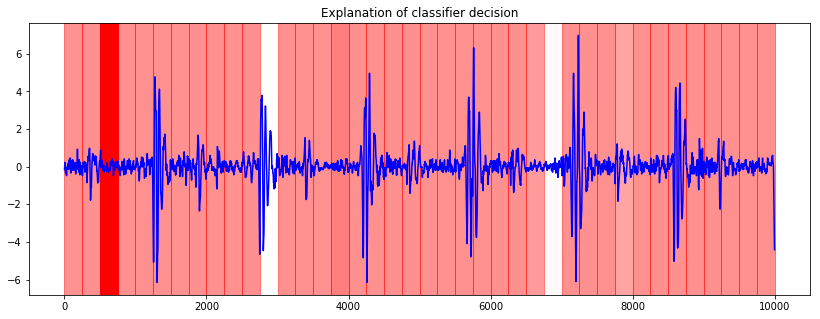

In [29]:
matplotlib.rcParams.update({'font.size': 10})
values_per_slice = math.ceil(len(instance) / num_slices)
plt.figure(figsize=(14,5))
plt.plot(instance, color='b', label='Explained instance')
plt.title("Explanation of classifier decision")
exp = explanation_.as_list(label=0)
weights = [(sample[1])*10**10  for sample in exp]
# weights = [0 if weight < 0 else weight for weight in weights]
# weights = [0.05 if 0 < weight < 0.01 else weight for weight in weights]
weights = [(weight-min(weights))/(max(weights)-min(weights)) for weight in weights]
print(weights)
for i in range(len(exp)):
    feature, _ = exp[i]
    weight = weights[i]
    start = feature * values_per_slice
    end = start + values_per_slice
    plt.axvspan(start , end, color='red',label=weight, alpha=(weight))
# plt.legend(loc='lower left')

[1.0, 0.7656668310816478, 0.7335987710811915, 0.12816019931405398, 0.1174676713988203, 0.07575339452851942, 0.0008174937886605375, 0.0008172568516251186, 0.0003482116217328842, 0.00022155172051905746, 0.0002213301893214201, 0.0001389552029090061, 6.103682580342033e-05, 1.9897789198463115e-07, 1.9875000492558053e-07, 1.4414126672565832e-07, 1.440610285167668e-07, 8.920201373694232e-08, 4.74711966615082e-08, 2.8948889130158386e-08, 1.585447457487707e-08, 2.750643996112682e-10, 2.2810903695753374e-10, 8.730220167661359e-11, 4.716071605597631e-11, 4.0161953703579146e-11, 4.015466132230104e-11, 4.0068848932626473e-11, 1.6593756269219674e-13, 1.659147463639757e-13, 5.609385370974109e-14, 1.9825294474735386e-14, 1.4239394434548378e-14, 1.2928460955176683e-14, 6.9009258259666495e-15, 8.358457317704764e-18, 4.102644909281673e-18, 4.099957190697456e-18, 9.865926291382424e-21, 0.0]


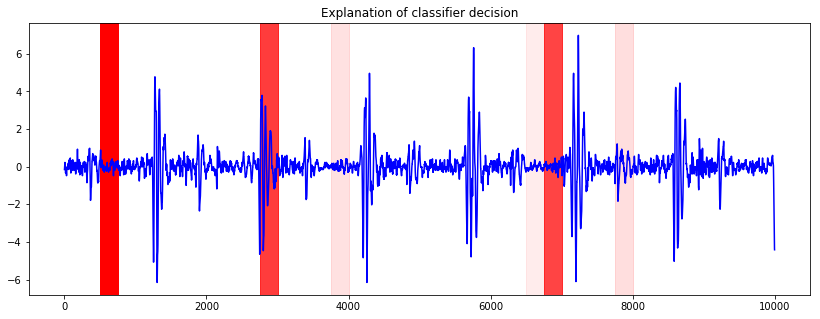

In [42]:
matplotlib.rcParams.update({'font.size': 10})
values_per_slice = math.ceil(len(instance) / num_slices)
plt.figure(figsize=(14,5))
plt.plot(instance, color='b', label='Explained instance')
plt.title("Explanation of classifier decision")
# plt.legend(loc='lower left')
exp = explanation_.as_list(label=1)
weights = [abs(sample[1])*10**10 for sample in exp]
# print(weights)
# weights = [0 if weight < 0 else weight for weight in weights]
weights = [(weight-min(weights))/(max(weights)-min(weights)) for weight in weights]
print(weights)
for i in range(len(exp)):
    feature, _ = exp[i]
    weight = weights[i]
    start = feature * values_per_slice
    end = start + values_per_slice
    plt.axvspan(start , end, color='red', label=weight,  alpha=weight)
# plt.legend(loc='lower left')

In [ ]:
explanation = explanations[1][1]
weights = [sample[1] if sample[1] > 0 else 0 for sample in explanation]
print(weights)
weights = [(weight-min(weights))/(max(weights)-min(weights)) for weight in weights]
# normalized_weights

In [ ]:
a = {'c': 2, 'b': 3}
b = a.copy()

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn.preprocessing import normalize

exp = explanations[0][1]

trace = go.Scatter(
    x=np.arange(0,10000,1),
    y=instance,
    mode='lines',
)
data = [trace]
layout = {'title':'Explanation of classifier decision','xaxis':{'title': 'Sample','showgrid': False},'yaxis':{'title': 'Magnitude', 'showgrid': False},'shapes': []}
shape = {'type': 'rect', 'xref': 'x', 'yref': 'paper', 'x0': 0, 'y0':0, 'x1': 0, 'y1':1, 'fillcolor':'#f24d50',
                     'opacity': 0.0, 'line': {'width': 0}, 'layer':'below'}
values_per_slice = math.ceil(len(instance) / num_slices)
weights = [abs(sample[1]) for sample in exp]
weights = weights[0:5]
normalized_weights = [(weight-min(weights))/(max(weights)-min(weights)) for weight in weights]
normalized_weights
for i in range(5):
    feature, _ = exp[i]
    weight = normalized_weights[i]
    if weight < 0.1:
        weight = 0.5
    elif weight < 0.01:
        weight = 0.1
    start = feature * values_per_slice
    end = start + values_per_slice
    shape1 = shape.copy()
    shape1.update({'x0':start, 'x1': end, 'opacity': weight})
    layout['shapes'].append(shape1)   
py.iplot({'data': data, 'layout': layout}, filename='timestamp-highlight')

In [ ]:
values_per_slice = math.ceil(len(instance) / num_slices)
plt.figure(figsize=(20,10))
plt.plot(instance, color='b', label='Explained instance')
# plt.plot(coffee_test_x.iloc[15:,:].mean(), color='green', label='Mean of other class')
plt.legend(loc='lower left')
exp = explanations[1][1]
for i in range(10):
    feature, weight = exp[i]
    start = feature * values_per_slice
    end = start + values_per_slice
    print(weight)
    plt.axvspan(start , end, color='red', alpha=(abs(weight*(10**20))))